In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import svm, datasets, linear_model
from sklearn.model_selection import GridSearchCV, cross_val_score
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import re

In [33]:
train_df = pd.read_csv("./data/train.csv")
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [34]:
train_df[train_df['target'] == 1]['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

<AxesSubplot:xlabel='target', ylabel='count'>

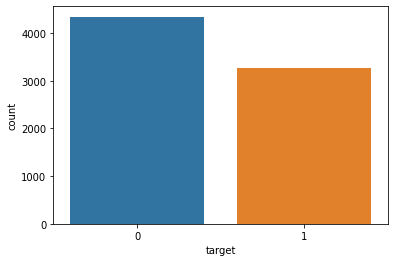

In [35]:
sns.countplot(x = 'target', data = train_df)

Balanced classes

In [36]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
def clean_text(text):
    text = re.sub('\d*', '', text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text)
    text = re.sub('#', '', text)                                             
    text = re.sub('@', '', text)
    text = re.sub(',', '', text)
    text = re.sub(':', '', text)
    text = re.sub('amp', '', text)
    #text = re.sub('В‰Г›_', '', text)
    text = re.sub('û_', '', text)
    return text.lower()

In [38]:
train_df['text'] = train_df['text'].apply(clean_text)

In [39]:
def show_rep_words(texts):
    d = {}
    for text in texts:
        tokens = re.findall('\w+-?\w*', text)
        for token in tokens:
            if token not in d.keys():
                d[token] = 1
            else:
                d[token] += 1
    sort_keys = sorted(d, key=d.get, reverse=True)
    sorted_dict = {}
    k = 0
    for w in sort_keys:
        sorted_dict[w] = d[w]
        k += 1
        if k > 10:
            break
    #for i in range(10):
     #   print(sorted_dict)
    
    print(sorted_dict)

Showing the freq of words before cleaning from stopwords:

In [40]:
show_rep_words(train_df[train_df['target'] == 0]['text'])  # 0 class

{'the': 1895, 'i': 1388, 'a': 1256, 'to': 1176, 'and': 896, 'of': 887, 'in': 814, 'you': 755, 'is': 592, 's': 544, 'my': 544}


In [41]:
show_rep_words(train_df[train_df['target'] == 1]['text'])  # 1 class

{'the': 1342, 'in': 1141, 'a': 924, 'of': 918, 'to': 747, 'and': 493, 'on': 414, 'for': 391, 'i': 381, 's': 364, 'is': 348}


Cleaning from stopwords

In [42]:
nltk.download('stopwords')
stopwords = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
def filter_stopwords(text):
    tokens = re.findall('\w+-?\w*', text) 
    text = ' '.join([token for token in tokens if (token not in stopwords) & (token.isalpha())])
    return text
      

In [44]:
train_df['text'] = train_df['text'].apply(filter_stopwords)

Showing the freq of words again after cleaning from stopwords:

In [45]:
show_rep_words(train_df[train_df['target'] == 0]['text'])  # 0 class

{'like': 253, 'new': 163, 'get': 163, 'one': 128, 'body': 112, 'would': 101, 'people': 94, 'love': 89, 'know': 85, 'got': 85, 'back': 82}


In [46]:
show_rep_words(train_df[train_df['target'] == 1]['text'])  # 1 class

{'fire': 179, 'news': 139, 'disaster': 120, 'california': 114, 'suicide': 109, 'police': 107, 'people': 105, 'like': 93, 'hiroshima': 92, 'killed': 87, 'storm': 87}


Стемминг

In [47]:
stemmer = PorterStemmer()
def stemming(text):
    tokens = re.findall('\w+-?\w*', text)
    text = ' '.join([stemmer.stem(token) for token in tokens])
    return text

In [48]:
train_df['text'] = train_df['text'].apply(stemming)
train_df['text'].head()

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

Split data into train-val-test:

In [49]:
X_train, X_val, y_train, y_val = train_test_split(train_df, train_df.target, train_size = 0.8, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, X_train.target, train_size = 0.8, random_state=42)

In [50]:
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_features=100000) 

In [51]:
word_vectorizer.fit(X_train['text'])
train_w_features = word_vectorizer.transform(X_train['text'])
val_w_features = word_vectorizer.transform(X_val['text'])
test_w_features = word_vectorizer.transform(X_test['text']) 

Choosing the best parameter:C:[1e-4, 1e-2, 1, 10, 100]

In [52]:
grid={'C':[1e-4, 1e-2, 1, 10, 100]}
logreg=LogisticRegression(max_iter=5000)
logreg_cv=GridSearchCV(logreg,grid,cv=10, scoring='accuracy')
logreg_cv.fit(train_w_features, y_train)
preds = logreg_cv.predict(val_w_features)
print(logreg_cv.best_score_)
print(logreg_cv.best_params_)

0.7939176793348368
{'C': 1}


Test:

In [53]:
logreg = LogisticRegression(C=1, solver='sag')               
logreg.fit(train_w_features, y_train)
preds = logreg.predict(test_w_features)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       703
           1       0.83      0.68      0.75       515

    accuracy                           0.80      1218
   macro avg       0.81      0.79      0.79      1218
weighted avg       0.81      0.80      0.80      1218



Cross-validation:

In [55]:
scores = cross_val_score(logreg, train_w_features, y_train, cv=5, scoring='accuracy') #кросс-вал на тренировочном наборе
scores.mean()

0.7894059916811458

In [59]:
#обучение на всем трэйне
word_vectorizer.fit(train_df['text'])
train_df_w_features = word_vectorizer.transform(train_df['text'])
test_features = word_vectorizer.transform(X_test['text'])
logreg = LogisticRegression(C=1, solver='sag') # лучшие параметры(выбраны выше)
logreg.fit(train_df_w_features, train_df.target)
preds = logreg.predict(test_features) # проверка на тесте
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       703
           1       0.94      0.76      0.84       515

    accuracy                           0.88      1218
   macro avg       0.89      0.86      0.87      1218
weighted avg       0.89      0.88      0.88      1218

